# Feature Selection

In [1]:
from src.features.helpers.load_data import load_data
from src.models.model_2.model.pipelines_2h import pipeline
import pandas as pd

train_data, augmented_data, test_data = load_data('2_00h')

all_train_data_transformed = pipeline.fit_transform(pd.concat([train_data, augmented_data]))
X_train, y_train = all_train_data_transformed.iloc[len(train_data):].drop(columns=['bg+1:00']), all_train_data_transformed.iloc[len(train_data):]['bg+1:00']

## Model Selection

Based on the results from the `LazyPredict` library we can select the best performing models from each category, fine tune them and use them in a `StackingRegressor` for the final prediction. 

In this case we will use:
 
* `HistGradientBoostingRegressor`
* `LassoLarsICRegressor`
* `KNNRegressor`
* `XGBRegressor`

## Feature Importance

For each of the models we can calculate the feature importance and choose the most important features.

### HistGradientBoostingRegressor

In [2]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)
importances = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
hgb_feature_importances = pd.Series(importances.importances_mean, index=X_train.columns)
hgb_feature_importances = hgb_feature_importances / hgb_feature_importances.sum()
mask = ~(hgb_feature_importances.index.str.startswith('hour') | hgb_feature_importances.index.str.startswith('p_num'))
hgb_feature_importances = hgb_feature_importances[mask]
hgb_feature_importances = pd.DataFrame(hgb_feature_importances, columns=['hgb_importance'])

### LassoLarsICRegressor

In [3]:
from sklearn.linear_model import LassoLarsIC

model = LassoLarsIC()
model.fit(X_train, y_train)
lasso_feature_importances = pd.Series(abs(model.coef_), index=X_train.columns)
lasso_feature_importances = lasso_feature_importances / lasso_feature_importances.sum()
mask = ~(lasso_feature_importances.index.str.startswith('hour') | lasso_feature_importances.index.str.startswith('p_num'))
lasso_feature_importances = lasso_feature_importances[mask]
lasso_feature_importances = pd.DataFrame(lasso_feature_importances, columns=['lasso_importance'])

### XGBRegressor

In [4]:
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

model = XGBRegressor()
model.fit(X_train, y_train)
importances = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
xgb_feature_importances = pd.Series(importances.importances_mean, index=X_train.columns)
xgb_feature_importances = xgb_feature_importances / xgb_feature_importances.sum()
mask = ~(xgb_feature_importances.index.str.startswith('hour') | xgb_feature_importances.index.str.startswith('p_num'))
xgb_feature_importances = xgb_feature_importances[mask]
xgb_feature_importances = pd.DataFrame(xgb_feature_importances, columns=['xgb_importance'])

## Plotting Feature Importance by parameter

Taking the sum of the feature importance from the three models we can plot the most important features.  

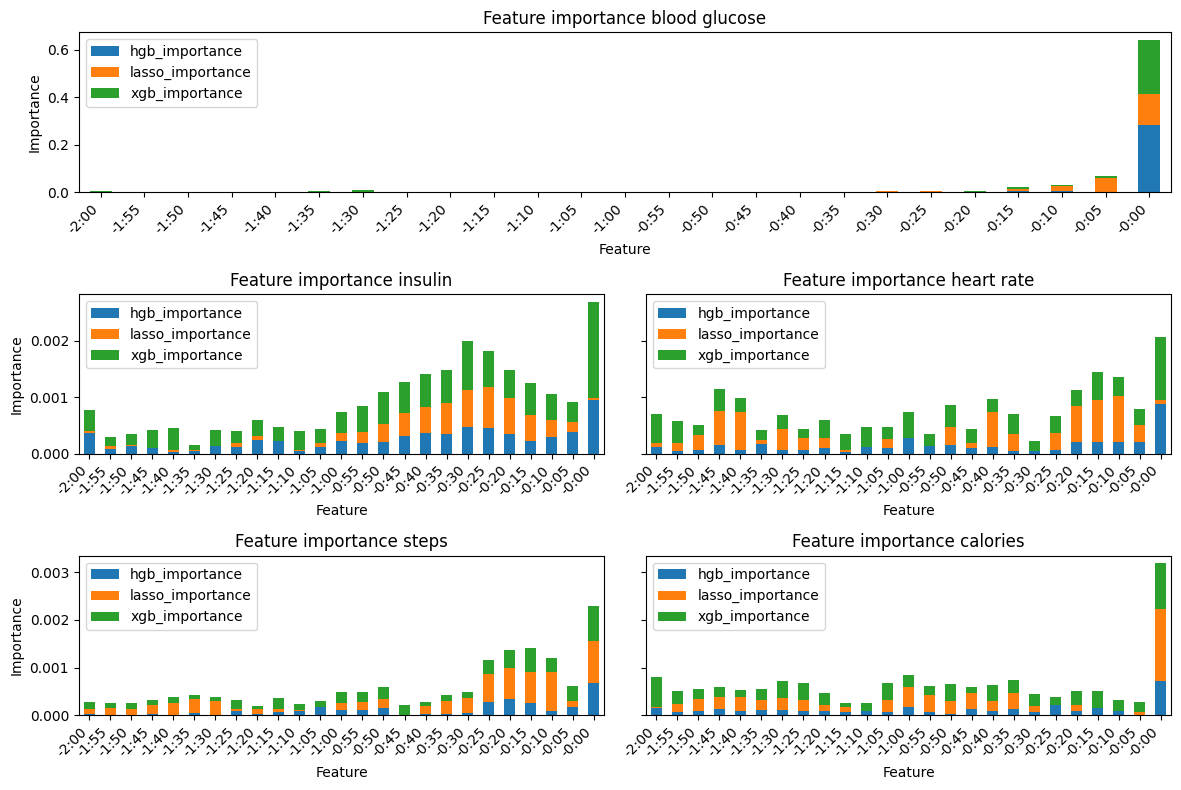

In [5]:
from helpers import plot_feature_importance_chart
%matplotlib inline

feature_importances = pd.concat([hgb_feature_importances, lasso_feature_importances, xgb_feature_importances], axis=1)
feature_importances = feature_importances / len(feature_importances.columns)

plot_feature_importance_chart(feature_importances)

The chart shows, that the most important features are the blood glucose levels until -0:30h, the insulin levels until -1:00h, the heart rate until -1:00h, the steps until -1:00h and the calories until -1:00h.

## Feature Selection

For the modelling section we will choose the following features:

* bg-0:00 - bg-1:00
* insulin-0:00 - insulin-1:00
* hr-0:00 - hr-1:00
* steps-0:00 - steps-1:00
* cals-0:00 - cals-1:00